
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic DWTs timeseries 

inputs required: 
  * Fitted the ALR model of DWT based on seasonality,and  AWT and IWT timeseries 
  * Synthetic timeseries of AWT and IWT
  
in this notebook:
  * Generate *n* simulations of 1000 years of DWTs timeseries (using the fitted ALR model)

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import shutil

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.alr import ALR_WRP
from teslakit.util.time_operations import xds_reindex_daily, xds_common_dates_daily

from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT, Plot_Probs_WT_WT_anomaly

from teslakit.io.aux_nc import StoreBugXdset



## Database and Site parameters

In [2]:
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('ROI_CC_S5')

#  copy alr_w folder to climate change path
shutil.copytree(db.paths.site.ESTELA.alrw, db_S5.paths.site.ESTELA.alrw) 
 

'/Users/albacid/Projects/TeslaKit_projects/sites/ROI_CC_S5/ESTELA/alr_w'

In [3]:
# --------------------------------------
# load data and set parameters

KMA_fit = db.Load_ESTELA_KMA()            # Historical bmus. ESTELA + TCs Predictor
MJO_sim_all = db.Load_MJO_sim()           # MJO simulations (daily)
PCs_sim_all = db_S5.Load_SST_PCs_sim_d()  # SST PCs simulations climate change (daily)

# ALR fit parameters
alr_num_clusters = 42
alr_markov_order = 1
alr_seasonality = [2, 4]

# ALR simulation
num_sims = 100  # one simulation for each simulated MJO, SST 


In [4]:
# --------------------------------------
# Data used to FIT ALR model and preprocess: 

# KMA: bmus (daily) (use sorted_bmus_storms, add 1 to get 1-42 bmus set)
BMUS_fit = xr.Dataset(
    {
        'bmus':(('time',), KMA_fit['sorted_bmus_storms'].values[:] + 1),
    },
    coords = {'time': KMA_fit.time.values[:]}
)



## ESTELA Predictor - Autoregressive Logistic Regression Simulation

In [5]:
# --------------------------------------
# Prepare Covariates for ALR simulations

# simulation dates
d_sim = xds_common_dates_daily([MJO_sim_all, PCs_sim_all])

# join covariates for all MJO, PCs simulations
l_cov_sims = []
for i in MJO_sim_all.n_sim: 

    # select simulation
    MJO_sim = MJO_sim_all.sel(n_sim=i)
    PCs_sim = PCs_sim_all.sel(n_sim=i)

    # PCs covar 
    cov_PCs = PCs_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_1 = cov_PCs.PC1.values.reshape(-1,1)
    cov_2 = cov_PCs.PC2.values.reshape(-1,1)
    cov_3 = cov_PCs.PC3.values.reshape(-1,1)

    # MJO covars
    cov_MJO = MJO_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
    cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

    # join covars (do not normalize simulation covariates)
    cov_T_sim = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))
    cov_sim = xr.Dataset(
        {
            'cov_values': (('time','n_covariates'), cov_T_sim),
            'cov_names': (('n_covariates',), ['PC1','PC2','PC3','MJO1','MJO2']),
        },
        coords = {'time': d_sim}
    )
    l_cov_sims.append(cov_sim)

# use "n_sim" name to join covariates (ALR.Simulate() will recognize it)
cov_sims = xr.concat(l_cov_sims, dim='n_sim')
cov_sims = cov_sims.squeeze()

print(cov_sims)


<xarray.Dataset>
Dimensions:     (n_covariates: 5, n_sim: 100, time: 365244)
Coordinates:
  * time        (time) object 2000-01-01 2000-01-02 ... 2999-12-31 3000-01-01
Dimensions without coordinates: n_covariates, n_sim
Data variables:
    cov_values  (n_sim, time, n_covariates) float32 13.679495 ... -0.60101
    cov_names   (n_sim, n_covariates) <U4 'PC1' 'PC2' 'PC3' ... 'MJO1' 'MJO2'


In [6]:
# --------------------------------------
# Autoregressive Logistic Regression

# ALR wrapper
ALRW = ALR_WRP(db_S5.paths.site.ESTELA.alrw)

ALRW.LoadModel()
ALRW.LoadBmus_Fit()


<xarray.Dataset>
Dimensions:  (time: 13625)
Coordinates:
  * time     (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2016-06-01
Data variables:
    bmus     (time) int64 ...
Attributes:
    cluster_size:  42

In [8]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

num_sims = 10

# launch simulation
xds_alr = ALRW.Simulate(num_sims, d_sim, cov_sims)

# Store Daily Weather Types
DWT_sim = xds_alr.evbmus_sims.to_dataset()
db_S5.Save_ESTELA_DWT_sim(DWT_sim)

print(DWT_sim)


ALR model fit   : 1979-02-12 --- 2016-06-01
ALR model sim   : 2000-01-01 --- 3000-01-01

Launching 10 simulations...

Sim. Num. 010 (Covs. 010): 100%|██████████| 365243/365243 [10:49<00:00, 562.63it/s]

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 365244)
Coordinates:
  * time         (time) object 2000-01-01 2000-01-02 ... 2999-12-31 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 27 27 27 27 27 27 27 ... 27 33 17 20 22 36
Attributes:
    source:   teslakit_v0.9.1


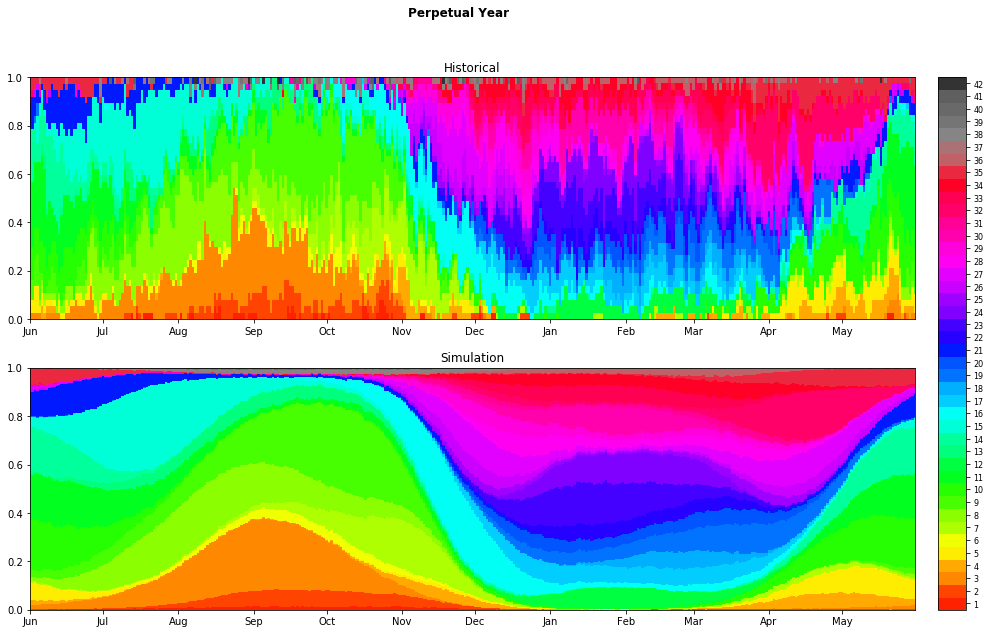

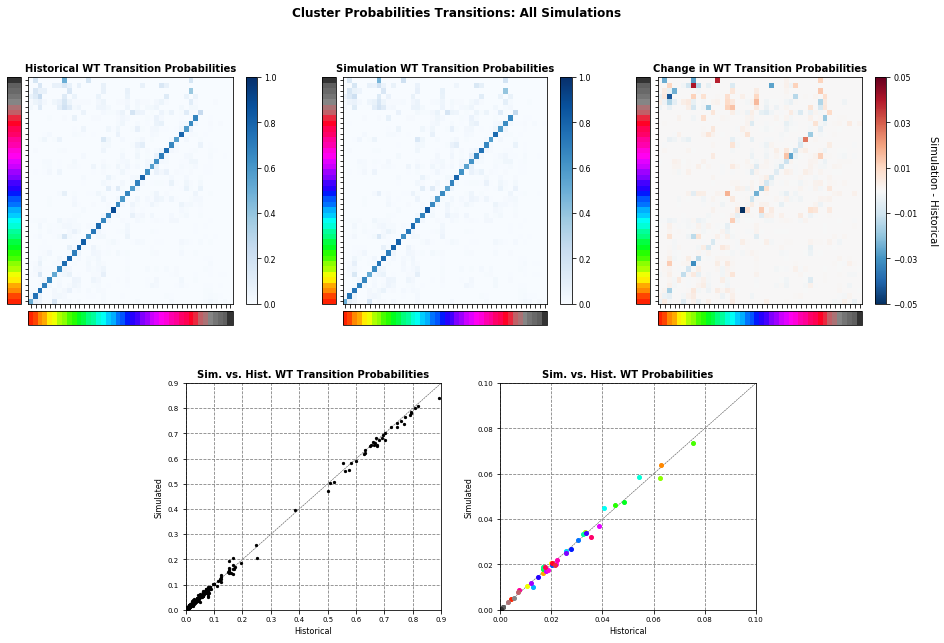

In [9]:
# show sim report
ALRW.Report_Sim(py_month_ini=6);


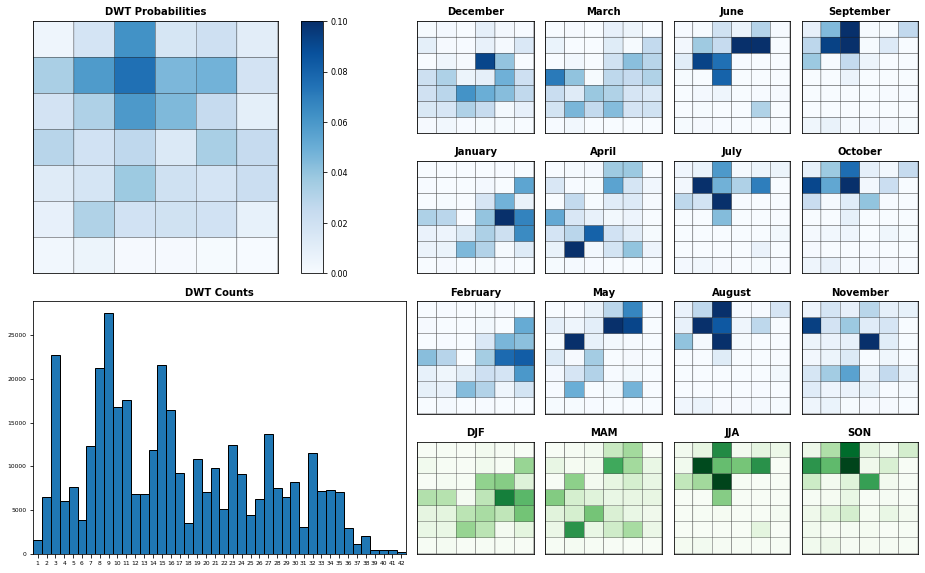

In [10]:
# Plot Simulated DWTs probabilities (with TCs DWTs)

bmus_sim = DWT_sim.isel(n_sim=0).evbmus_sims.values[:]
dbmus_sim = DWT_sim.time.values[:]

Plot_DWTs_Probs(bmus_sim, dbmus_sim, alr_num_clusters);


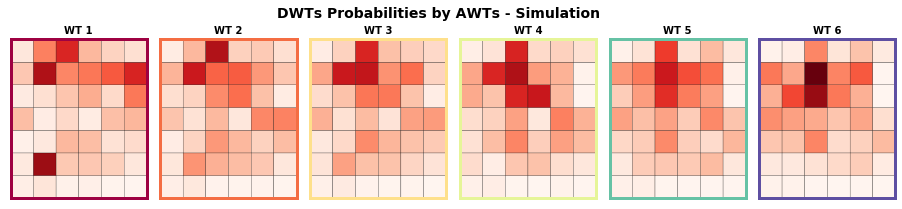

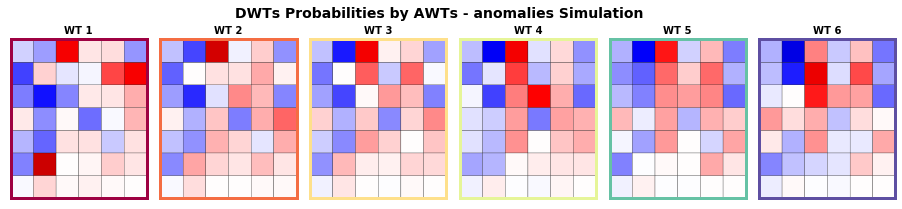

In [11]:
# Plot AWTs/DWTs Probabilities 

# clusters to plot (no TCs)
n_clusters_AWT = 6
n_clusters_DWT = 42
n_sim = 0  # simulation to plot

# Plot AWTs/DWTs sim - simulated
AWT_sim, DWT_sim = db_S5.Load_AWTs_DWTs_Plots_sim(n_sim=0)
AWT_bmus = AWT_sim.bmus.values[:]
DWT_bmus = DWT_sim.bmus.values[:]


Plot_Probs_WT_WT(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - Simulation'
);


Plot_Probs_WT_WT_anomaly(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - anomalies Simulation'
);
